# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!


  1. Use RAGAS to Generate Synthetic Data
  2. Load them into a LangSmith Dataset
  3. Evaluate our RAG chain against the synthetic test data
  4. Make changes to our pipeline
  5. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU ragas==0.2.10

In [2]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DadaV\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DadaV\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [4]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"PSI - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "bills/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [8]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [9]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [10]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 86530b41-67b4-4f0b-b0c2-f9712b8d21c1 does not have a summary. Skipping filtering.
Node 625fb040-d38a-489c-bcd1-9ea3366cc437 does not have a summary. Skipping filtering.
Node a05d45d1-d61d-41aa-ba5e-726b842e842e does not have a summary. Skipping filtering.
Node c9dd4ee8-4b64-4613-bc96-dd20dab91550 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 20, relationships: 136)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("bills/ai_law.json")
bills_data_kg = KnowledgeGraph.load("bills/ai_law.json")
bills_data_kg

KnowledgeGraph(nodes: 20, relationships: 136)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=bills_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

</div>


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

* 1. Paraphraser
What it does:
- Rewrites the original query using different words or phrasing, while keeping the meaning the same.

Why it's helpful:
- Different words might match different documents, improving recall.

Simple example:
- Original query: "How do whales communicate?"

Paraphrased queries:

- "What methods do whales use to talk to each other?"
- "How do whales send messages underwater?"

* 2. Rewriter (Context-Aware Synthesizer)
What it does:
- Modifies the query based on context, such as previous conversation turns or metadata.
- Often used in conversational or multi-turn QA.

Why it's helpful:
- It resolves ambiguous or incomplete questions using extra context.

Simple example:
- Context: Previous user question: "Tell me about Tesla."

    User now asks: "What about their stock?"

- Rewritten query:

    "What is the current stock price of Tesla?"

3. Expander
What it does:
- Adds related concepts or subtopics to the original query to make it broader or more exploratory.

Why it's helpful:
- Useful when users ask vague or high-level questions — helps surface more diverse information.

Simple example:
- Original query: "Climate change impacts"

Expanded queries:

- "How does climate change affect agriculture?"
- "What are the economic effects of global warming?"

</span>


Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What are the main objectives and significance ...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The AI Act aims to regulate the development an...,single_hop_specifc_query_synthesizer
1,Considering the concerns raised about Artifici...,[AI presents enormous opportunities for the Ph...,The context indicates that the rise of Artific...,single_hop_specifc_query_synthesizer
2,What does Section 10 of the Artificial Intelli...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The provided context does not include specific...,single_hop_specifc_query_synthesizer
3,How is the term AI spelt in the context of the...,"[1 \na) Promote innovation, technological adva...",The term AI is spelled as Artificiai Inteiiige...,single_hop_specifc_query_synthesizer
4,What is the meaning of agi in AI research?,[1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11\n12\n13\n1...,Artificial General Intelligence (AGI) refers t...,single_hop_specifc_query_synthesizer
5,how AI threats to humanity and infrastructure ...,[<1-hop>\n\nAI presents enormous opportunities...,the first segment explains that AI in the phil...,multi_hop_abstract_query_synthesizer
6,How does the establishment of the NAIC relate ...,[<1-hop>\n\n1 \nk) Issue advisory opinions on ...,The establishment of the NAIC as a policy-maki...,multi_hop_abstract_query_synthesizer
7,How do the guidelines and risk thresholds outl...,[<1-hop>\n\n1 \niii) Mandatory compliance trai...,The guidelines established by the AI Ethics Re...,multi_hop_abstract_query_synthesizer
8,"How does the NAIC's regulation of AI, includin...",[<1-hop>\n\n1 \nd) Take full responsibility fo...,"The NAIC, which has jurisdiction over all matt...",multi_hop_specific_query_synthesizer
9,TWENTIETH CONGRESS AI law what it do,[<1-hop>\n\nTWENTIETH CONGRESS OF THE \nREPUBL...,The TWENTIETH CONGRESS OF THE PHILIPPINES pass...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [16]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 3092a74c-3ef9-443a-a7d0-7b10cf1ed575 does not have a summary. Skipping filtering.
Node e9aed826-da17-4116-8f58-42a343e69572 does not have a summary. Skipping filtering.
Node f429e0af-e86c-492f-b94c-8311c07edf43 does not have a summary. Skipping filtering.
Node 5fd47800-eb9f-4668-a1c8-73b3e007d5f3 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of regulating AI in t...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The regulation of AI in the Philippines aims t...,single_hop_specifc_query_synthesizer
1,Georgetown University how does it relate to AI...,[AI presents enormous opportunities for the Ph...,The context mentions Georgetown University in ...,single_hop_specifc_query_synthesizer
2,What does the PHILIPPINE CONSTITUTION say abou...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,"The context references Article XIV, Section 10...",single_hop_specifc_query_synthesizer
3,How does the regulation of Artificial General ...,"[1 \na) Promote innovation, technological adva...",The context states that policies should promot...,single_hop_specifc_query_synthesizer
4,How can the development of multimodal models e...,[<1-hop>\n\n1 \nground its responses in verifi...,The development of multimodal models can enhan...,multi_hop_abstract_query_synthesizer
5,How does the need for regulation and oversight...,[<1-hop>\n\n1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11...,The context highlights that while AI offers si...,multi_hop_abstract_query_synthesizer
6,How do the United Nations' recommendations for...,[<1-hop>\n\nTWENTIETH CONGRESS OF THE \nREPUBL...,The context highlights that international effo...,multi_hop_abstract_query_synthesizer
7,How does the regulation of AI responsibility f...,[<1-hop>\n\n1 \nd) Take full responsibility fo...,The regulation of AI responsibility for harms ...,multi_hop_abstract_query_synthesizer
8,how DOST and NAIC work together in AI regulati...,[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,"The NAIC, which is attached to the DOST, has j...",multi_hop_specific_query_synthesizer
9,How does TESDA's role in AI regulation relate ...,[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,"TESDA is listed as a member of the NAIC, which...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [18]:
from langsmith import Client

client = Client()

dataset_name = "Philippines AI Bills"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Philippines AI Bills"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [19]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [20]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [21]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [22]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [23]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG"
)

In [24]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [25]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [27]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [28]:
rag_chain.invoke({"question" : "How much is the penalty for spreading disinformation?"})

'The penalty for using AI to create or disseminate disinformation is a fine of One Million Pesos (Php 1,000,000) to Five Million Pesos (Php 5,000,000), or imprisonment of three (3) years to ten (10) years, or both, at the discretion of the court.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [29]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [30]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

* qa_evaluator:
- it evaluates how well the answer matches the question.
- it checks if the answer is factually accurate, relevant, and complete.
- focuses on accuracy and relevance to the question

* labeled_helpfulness_evaluator:
- it evaluates how helpful the answer is based on labeled human preferences.
- it focuses on clarity, usefulness, and alignment with human expectations — not just factual correctness.
- focuses more on overall helpfulness and human-like quality

</div>

## LangSmith Evaluation

In [31]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'sunny-collar-1' at:
https://smith.langchain.com/o/92af5c49-0a9e-4f85-beea-085fbd240cd1/datasets/861faf01-85b7-44d1-8a8c-72463fffb4fb/compare?selectedSessions=e8d888b5-35ee-41e8-8826-029ee1200071




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the DOST support AI policies and init...,"Based on the provided context, the Department ...",None,The DOST supports AI policies and initiatives ...,1,0,0,4.791891,0768fd5a-970b-482f-aa5c-ec1ef5a0d906,04542c45-45e0-45e1-a879-de8759084bea
1,How does TESDA collaborate with the NAIC to su...,I don't know.,None,TESDA collaborates with the NAIC by supporting...,0,0,0,0.839340,7baaaa67-bf6a-48fd-9255-d6d474fc30d3,3e050283-5746-4384-86c5-8a4f42d7b28f
2,How does TESDA's role in AI regulation relate ...,I don't know.,None,"TESDA is listed as a member of the NAIC, which...",0,0,0,0.951276,a2141d56-0bcd-4a44-83d0-ce71916c01d0,93bc09f3-6b12-4d7f-8660-f357ee2b978d
3,how DOST and NAIC work together in AI regulati...,Based on the provided context:\n\n- The Nation...,None,"The NAIC, which is attached to the DOST, has j...",1,1,0,4.042092,38c5205d-984d-4c7f-96b3-2001897dc841,96c61f03-4111-4115-b3a7-54b77e9154bf
4,How does the regulation of AI responsibility f...,The regulation of AI responsibility for harms ...,None,The regulation of AI responsibility for harms ...,1,1,0,3.763843,db67c379-1fa4-4938-a726-861cd73c7e19,409a45c1-a73b-4659-beee-c942b56e418a
5,How do the United Nations' recommendations for...,The United Nations Secretary-General's High-Le...,None,The context highlights that international effo...,1,1,0,4.104369,33a985ea-db0d-49d3-a7b7-22d7cd6567a1,dc07370d-6e91-4b07-9897-45a72d03b60d
6,How does the need for regulation and oversight...,I don't know.,None,The context highlights that while AI offers si...,0,0,0,0.785855,cdcf2c9c-9950-4642-b234-36eec086d17f,4e42a125-235a-4aa1-8298-3ee4ebee4ac0
7,How can the development of multimodal models e...,I don't know.,None,The development of multimodal models can enhan...,0,0,0,1.392416,b8033ddb-c877-49df-acac-bebfecc89e36,12e8370a-2741-4aa7-a124-e5511570d0e3
8,How does the regulation of Artificial General ...,The regulation of Artificial General Intellige...,None,The context states that policies should promot...,1,1,0,3.500105,fdb75978-1d94-4b8d-b2c2-54e67e231d59,6f1c8624-6679-4402-b998-0846decfa143
9,What does the PHILIPPINE CONSTITUTION say abou...,"The context includes a reference to ""Article X...",None,"The context references Article XIV, Section 10...",1,0,0,1.565490,1f7ddec1-711c-4e11-bca1-351189c11a8d,6df07fd5-e014-4444-ab3c-4994ec2df025


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [32]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [33]:
rag_documents = docs

In [34]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

Why Chunk Size Affects Performance:

1. Too Small = Loss of Context
Small chunks may miss the full meaning of a topic.

When retrieved, they may not provide enough information for the model to give a good answer.

Example: A paragraph explaining a concept gets split into two chunks → neither chunk makes full sense alone.

2. Too Large = Lower Retrieval Accuracy
Large chunks might contain irrelevant content along with useful info.

This can confuse the retriever and dilute the relevance score.

Example: A chunk contains both “how to reset a password” and “how to delete an account.” It’s less precise.

3. Affects Recall and Precision Tradeoff
Smaller chunks → higher recall (more chance to find relevant info).

Larger chunks → better precision (more info per chunk but may miss others).

4. Impacts Embedding Quality
Some embedding models (like OpenAI’s) perform best with chunks under 512–1024 tokens.

Too large: embeddings may be less meaningful.

Too small: embeddings may lack context.

5. Affects Token Usage & Cost
Larger chunks retrieved = more tokens passed to the LLM → higher cost & latency.

Smaller chunks retrieved = potentially more chunks retrieved → also higher cost if not managed.

</div>

In [35]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

Why Changing the Embedding Model Affects Performance:

1. Semantic Understanding Quality
Some models are better at understanding meaning and context.

A better model = more relevant documents retrieved.

Example:
Query: “How do I reverse a transaction?”

Weak model: matches a chunk that talks about “transactions” generally.

Strong model: matches a chunk that specifically explains how to reverse a transaction.

2. Domain Fit
Some embedding models are trained on general language (like OpenAI’s text-embedding-3-small), while others are trained on specific domains (like legal, code, finance, etc).

Using a domain-specific model improves retrieval accuracy in that domain.

Example: Using a legal-specific embedding model in a law app retrieves far more relevant legal content.

3. Embedding Size and Cost
Different models output vectors of different sizes (e.g., 384-dim vs 1536-dim).

Larger vectors = more storage, more compute, and slower similarity search.

Smaller vectors = faster, but may lose detail.

4. Multilingual Support
Some models (like LaBSE or multilingual MiniLM) can handle multiple languages.

If your users speak different languages, the right model is essential for accurate cross-language retrieval.

5. Latency & Hosting
Cloud-hosted models (e.g., OpenAI) = simple, high-quality, but adds network latency.

Local models (e.g., all-MiniLM via Hugging Face) = faster and cheaper but may be less powerful.

</div>

In [36]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG 2"
)

In [37]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [38]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [39]:
empathy_rag_chain.invoke({"question" : "Why is the Philippines AI Bill important?"})

'Thank you for your thoughtful question. Based on the context provided, the Philippines AI Bill is important because it aims to create a national framework that balances the encouragement of technological innovation with ensuring that AI systems are safe, ethical, transparent, and under meaningful human oversight. It recognizes the transformative impact of AI on industries and society and seeks to promote responsible and lawful AI development that supports Filipino ingenuity and addresses national development challenges.\n\nMoreover, the bill emphasizes protecting the rights and welfare of every citizen by preventing AI from being used to commit crimes, abuse rights, or cause harm, whether intentionally or accidentally. This shows a deep concern for the well-being of the people while fostering progress and innovation in technology.\n\nIt’s clear that the bill strives to create a secure, inclusive, and ethical digital future for the Philippines, thoughtfully anticipating both the opport

Finally, we can evaluate the new chain on the same test set!

In [40]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'complicated-station-33' at:
https://smith.langchain.com/o/92af5c49-0a9e-4f85-beea-085fbd240cd1/datasets/861faf01-85b7-44d1-8a8c-72463fffb4fb/compare?selectedSessions=112f58bd-e760-499e-9456-900ca391a6b3




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the DOST support AI policies and init...,Thank you for your thoughtful question. From t...,None,The DOST supports AI policies and initiatives ...,1,1,1,5.705640,0768fd5a-970b-482f-aa5c-ec1ef5a0d906,c5f0d260-aa2b-4ab3-bdc3-508429074e06
1,How does TESDA collaborate with the NAIC to su...,Thank you for your thoughtful question. Based ...,None,TESDA collaborates with the NAIC by supporting...,1,1,1,5.433222,7baaaa67-bf6a-48fd-9255-d6d474fc30d3,2dea2471-7639-479e-8b25-dc6a1333f59b
2,How does TESDA's role in AI regulation relate ...,Thank you for your thoughtful question. From t...,None,"TESDA is listed as a member of the NAIC, which...",1,1,1,5.652752,a2141d56-0bcd-4a44-83d0-ce71916c01d0,a8a0436f-3524-477c-8046-67d06d6d5fcb
3,how DOST and NAIC work together in AI regulati...,Thank you for your thoughtful question. From t...,None,"The NAIC, which is attached to the DOST, has j...",1,1,1,9.333190,38c5205d-984d-4c7f-96b3-2001897dc841,57be7d9d-48b4-4781-8139-4d9421ecf097
4,How does the regulation of AI responsibility f...,Thank you for your thoughtful question. Based ...,None,The regulation of AI responsibility for harms ...,1,1,1,4.489557,db67c379-1fa4-4938-a726-861cd73c7e19,47964008-2975-4263-97db-ba3c15d056ea
5,How do the United Nations' recommendations for...,Thank you for your thoughtful question. From t...,None,The context highlights that international effo...,1,1,1,5.487013,33a985ea-db0d-49d3-a7b7-22d7cd6567a1,2abf25db-1383-477d-b5d0-dece432f7ad8
6,How does the need for regulation and oversight...,Thank you for your thoughtful question. It's c...,None,The context highlights that while AI offers si...,1,1,1,10.912735,cdcf2c9c-9950-4642-b234-36eec086d17f,951709d5-a3cd-4d29-a8de-5c65a50c48e1
7,How can the development of multimodal models e...,Thank you for your thoughtful question. From t...,None,The development of multimodal models can enhan...,1,1,1,7.673174,b8033ddb-c877-49df-acac-bebfecc89e36,29c0abb1-dead-4a86-8f72-48abd4795d36
8,How does the regulation of Artificial General ...,Thank you for your thoughtful question. Based ...,None,The context states that policies should promot...,1,1,1,5.787368,fdb75978-1d94-4b8d-b2c2-54e67e231d59,42463c9f-beca-4058-bd5d-51a25fec38db
9,What does the PHILIPPINE CONSTITUTION say abou...,Thank you for your question about what the Phi...,None,"The context references Article XIV, Section 10...",0,0,1,2.799059,1f7ddec1-711c-4e11-bca1-351189c11a8d,b2306d1c-746d-4483-ab9b-2167cbc9a440


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #4:

Explain why you believe certain metrics changed in certain ways, and provide a screenshot of the difference between the two chains.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

By 
- using different embedding models, and/or 
- using different chunk sizes, and/or
- switching from standard RAG to multi-query RAG, and/or
- adjusting number of documents retrieved

Results:
- Precsion is increased as retriever may find more relevant documents, possibly due to better embeddings or fewer irrelevant chunks.
- Recall is likely increased due to using multi-query retrieval, smaller chunks, or increasing k (number of retrieved docs).
- Latency is increased sinces more queries, larger chunk sizes, or more documents sent to the LLM.
- Cost is increased since more tokens processed (e.g., due to more retrieved docs or longer chunks).
- F1 score is improved likely due to better overall chunking or embedding match.

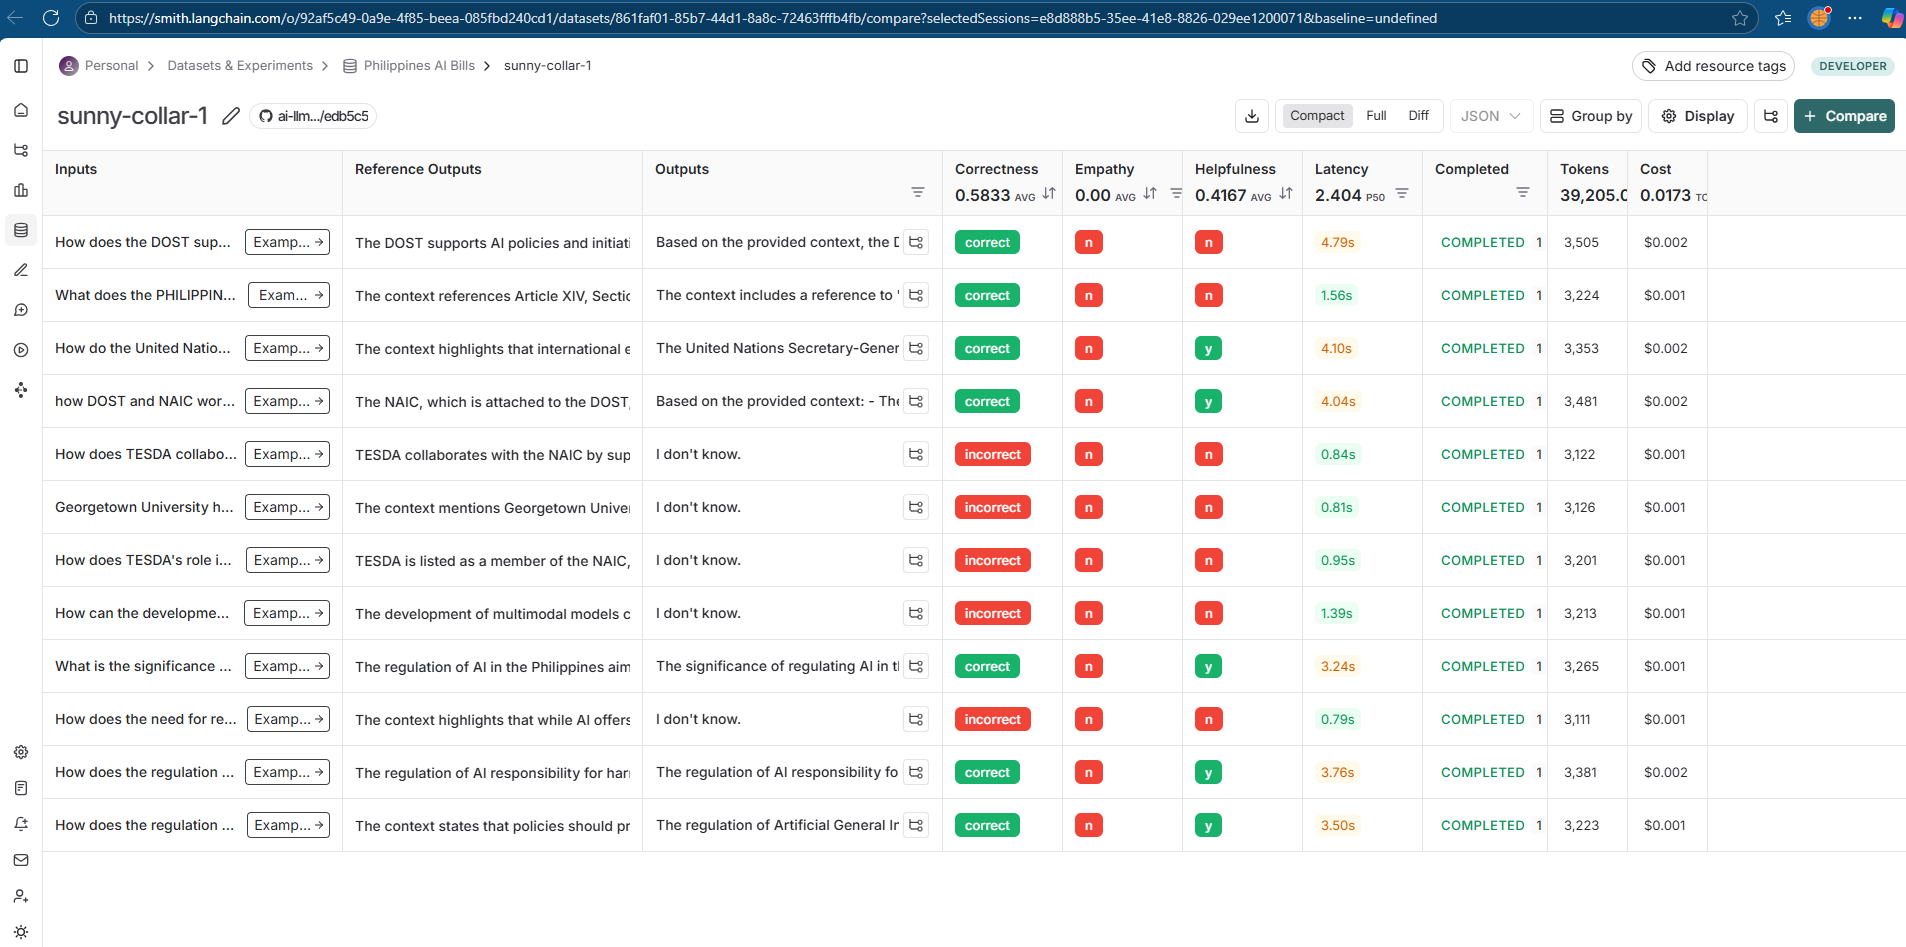
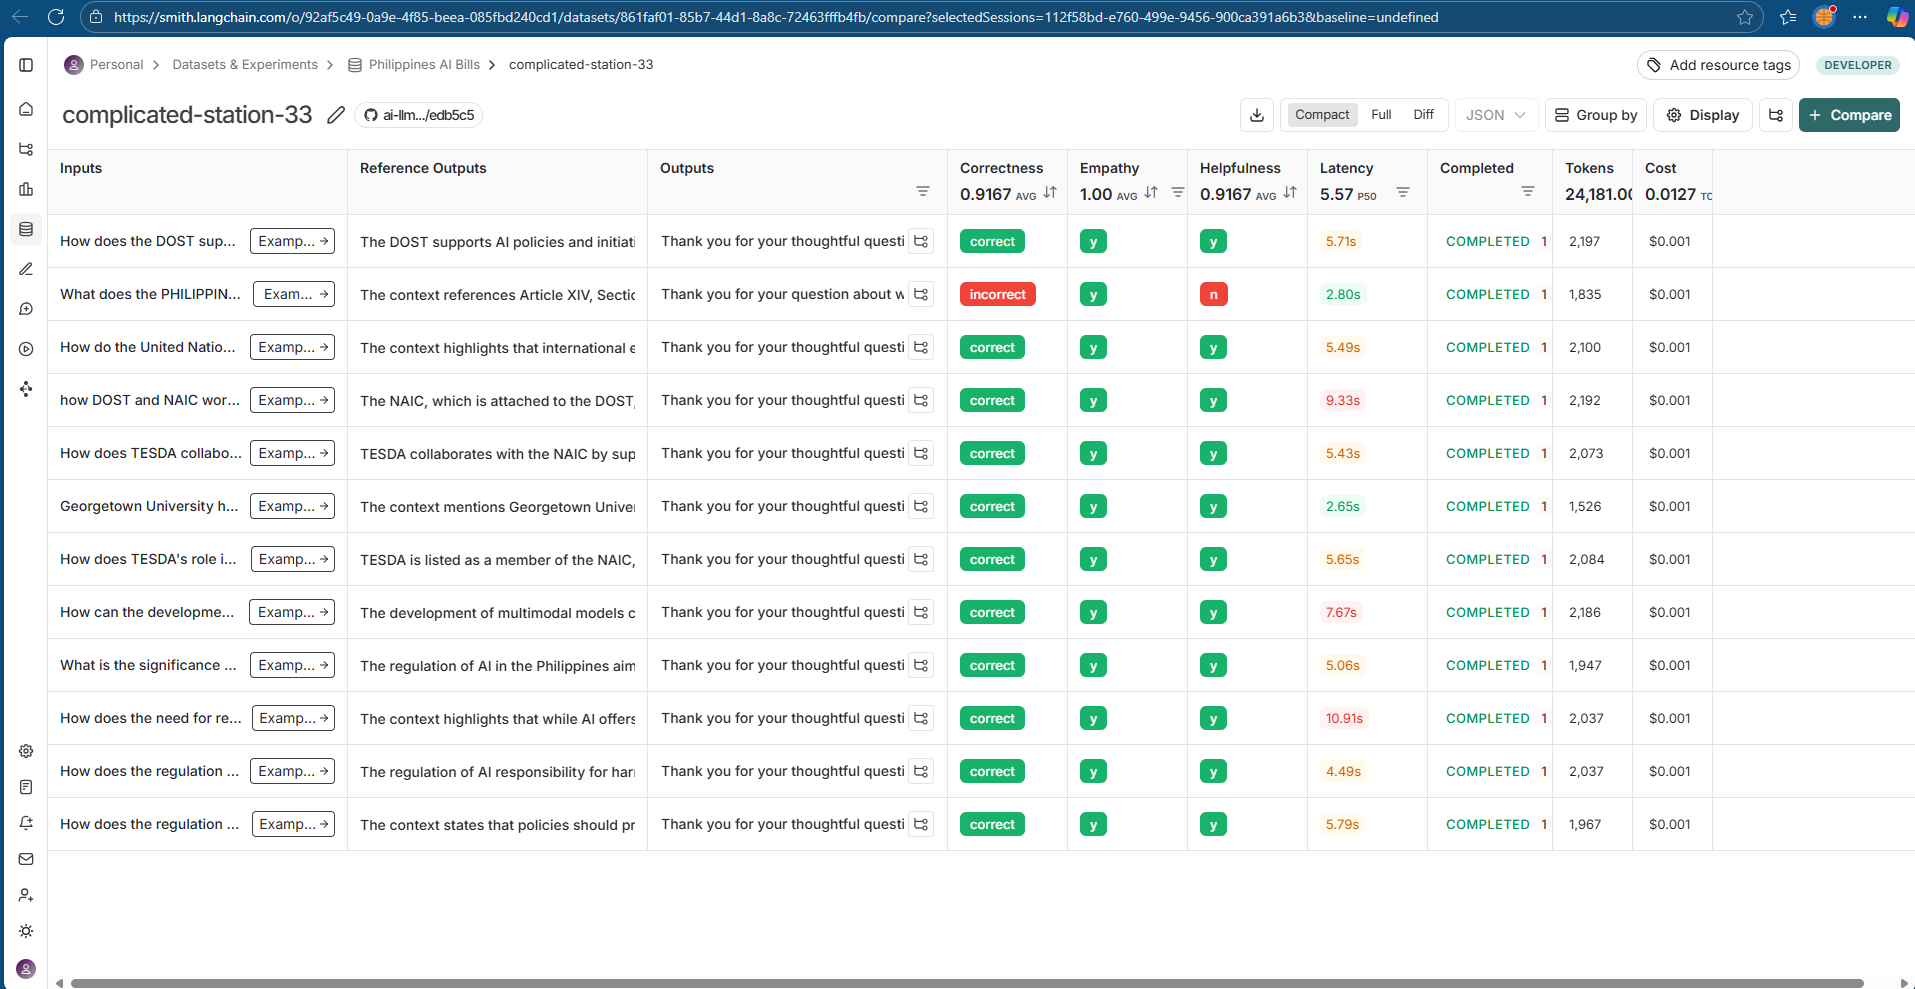
</div>